# Study on Heart Disease Database

### Introduction:
Heart disease affects millions of people every year. In order to help prevent and potentially save lives, it is important to predict what can help prevent and detect these diseases in the early stages. With database we are using, we aim to investigate the relationship between different factors such as age, sex, number of major blood vessels colored by fluoroscopy, resting blood pressure, maximum heart rate achieved, cholesterol, and percentage of narrowing in any major vessel (condition). The condition can be 0, which means the patient has no heart disease, and 1, which means the patient does have heart disease.

The question we will be answering with this project is: how do age, resting blood pressure, maximum heart rate achieved, and cholesterol influence the percentage of narrowing of in any major vessel (condition)?

The dataset we will utilize is "Study on Heart Disease Database” from "https://archive.ics.uci.edu/dataset/45/heart+disease". For our analysis, we'll primarily be focusing on the Cleveland database. The data that we will be using has already been cleared of all N/A values. 

In [1]:
install.packages("GGally")
install.packages("kknn")
install.packages("gridExtra")
library(kknn)
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(GGally)
set.seed(1120)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ──────────────────────

These are the general packages needed to run our code. 

In [2]:
cleveland <- read_csv("https://raw.githubusercontent.com/ChristianGoncalvesOG/DSCI-100-009-013/main/heart_cleveland_upload.csv")

head(cleveland, n = 3)

Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
66,0,0,150,226,0,0,114,0,2.6,2,0,0,0


There are 297 rows and 14 columns in this data set.

In [3]:
cleveland_selected <- cleveland |>
    select(age, sex, ca, trestbps, thalach, chol, condition) |>
    mutate(condition = as_factor(condition)) |>
    na.omit()

head(cleveland_selected, n = 3)

age,sex,ca,trestbps,thalach,chol,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,1,1,160,131,234,0
69,0,2,140,151,239,0
66,0,0,150,114,226,0


An important thing to note is our data set is already in tidy format, so we didn't need to wrangle it into tidy format. Our first step after reading in the data set was to select only the variable we care about, which are age, sex, ca (number of major blood vessels), trestbps (resting blood pressure when the patient was admitted to the hospital), thalach (the maximum heart rate achieved), cholesterol, and the condition of the patient (heart disease or not). Next, we mutated condition to be a factor, as that's what we are interested in predicting. We also cleared all possiblities of N/A values existing in this set. 

In [4]:
cleveland_split <- initial_split(cleveland_selected, prop = 0.75, strata = condition)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

The data set was then split into training and test, with 75% being for training and 25% for testing.

In [5]:
cleveland_table_sum <- cleveland_train |>
    group_by(condition) |>
    summarize(numOfRows = n())

cleveland_table_mean <- cleveland_train |>
    group_by(condition) |>
    select(age, trestbps, chol, thalach) |>
    summarize(average_age = mean(age), average_trestbps = mean(trestbps), average_chol = mean(chol), average_thalach = mean(thalach))

cleveland_table <- cleveland_table_sum |>
    full_join(cleveland_table_mean)

cleveland_table
#Generating the table

Adding missing grouping variables: `condition`
Joining with `by = join_by(condition)`


condition,numOfRows,average_age,average_trestbps,average_chol,average_thalach
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,120,53.01667,128.7750,245.4333,157.6333
1,102,57.05882,136.1569,251.8039,139.6667


Next, we decided to make a table to show the average values for each of the conditions (has heart disease and does not). First, using our training data we grouped by the condition as that's the predictive variable we care about. Then we also summarized to find the number of rows of each of the values. After this we collected the mean of all the variables we cared about. An important thing to note is while doing this we realized that sex and ca are not good variable to use in our classification model, as both of them only have a set amount of values they can be, and we haven't learned how to make models with these. So instead we averaged all of the other values, which have a range of values they can be, grouping by condition. Lastly, using full_join we joined both of these tables together to create the table above!

In [6]:
cleveland_graph <- ggplot(cleveland_train, aes(x = age, y = chol, color = condition)) +
                geom_point() + 
             labs(x = "Age \n(Years)", y = "Cholesterol \n (mg/dl)", color = "Condition") + ggtitle("Age vs Cholesterol")


In [7]:
cleveland_graph2 <- ggplot(cleveland_train, aes(x = trestbps, y = thalach, color = condition)) + 
            geom_point() + 
            labs(x = "Resting Blood Pressure \n (mm/Hg)", y = "The Maximum Heartrate Achieved \n (bpm)", color = "Condition") + ggtitle("Resting Blood Pressure vs Maximum Heartrate Achieved")


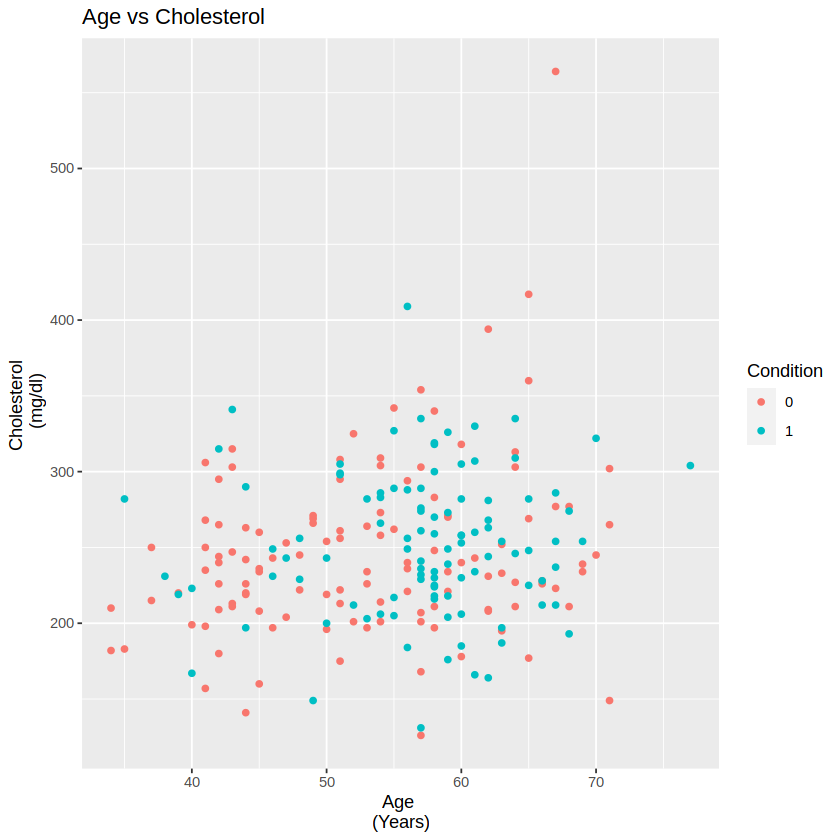

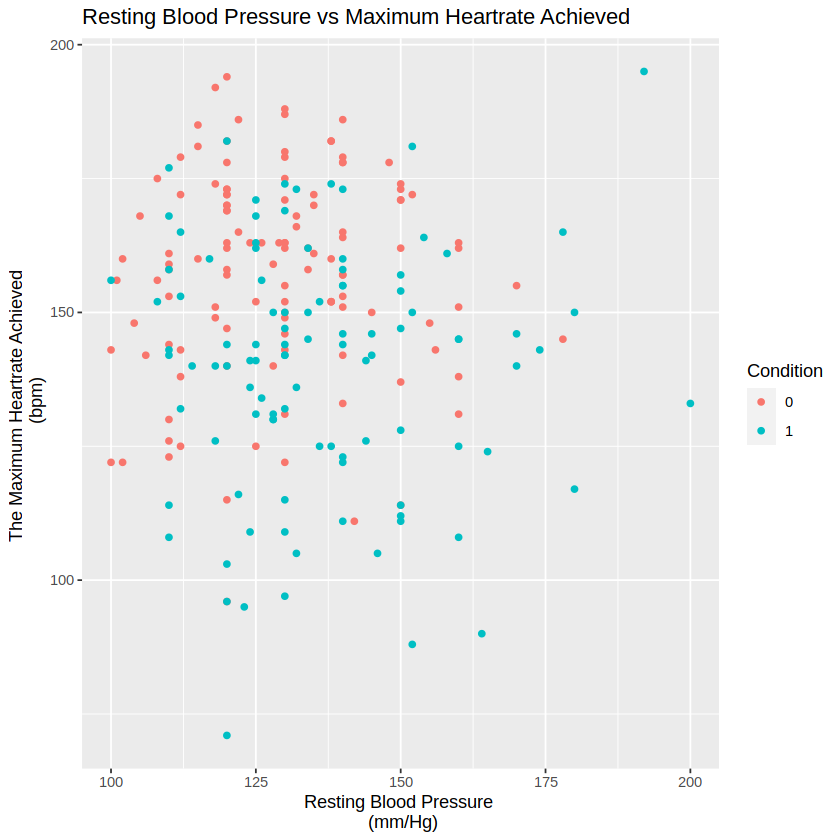

In [8]:
cleveland_graph
cleveland_graph2

In the first graph, of how age and cholesterol, there's less of a clear difference between condition 0 and 1. Most of the individual plots are quite close to each other, and there's no clear distinction or certain area where there's more of condition 0 or 1. One could say that condition 0's age is slightly younger than condition 1, however we would say it's not enough to show any big relationship between these variables. In the second graph of resting blood pressure and maximum heart rate there's a bit of a stronger distinction. Condition 1 seems to be more focused in the bottom right, where as condition 0 is more in the top left. This means that graph 2 would be better to do a classification model with than the second graph.

We expect to find the relationship of how ones condition is impacted by age and one other variable, such as blood pressure, cholesterol, and max heart rate achieved. 

In [9]:
cleveland_test_k <- tibble(neighbors = seq(1,20,1))
cleveland_fold <- vfold_cv(cleveland_train, 5, strata = condition)

cleveland_recipe <- recipe(condition ~ trestbps + thalach + chol, data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

cleveland_kknn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cleveland_kknn) |>
    tune_grid(resamples = cleveland_fold, grid = 10)

cleveland_results <- cleveland_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")
cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6085859,5,0.03162560,Preprocessor1_Model1
3,accuracy,binary,0.6529293,5,0.02183630,Preprocessor1_Model2
5,accuracy,binary,0.6890909,5,0.01367988,Preprocessor1_Model3
6,accuracy,binary,0.6890909,5,0.01367988,Preprocessor1_Model4
8,accuracy,binary,0.6621212,5,0.02965253,Preprocessor1_Model5
9,accuracy,binary,0.6574747,5,0.02020354,Preprocessor1_Model6
11,accuracy,binary,0.6574747,5,0.01733023,Preprocessor1_Model7
13,accuracy,binary,0.6484848,5,0.02018876,Preprocessor1_Model8
14,accuracy,binary,0.6484848,5,0.02018876,Preprocessor1_Model9


The neighbours table is a summary output of the k-nearest neighbors model's performance, specifically showing the accuracy metric for different values of 'k', the number of neighbors considered. We used this table to fine-tune our model, examining how the number of neighbors impacts the model's accuracy in predicting heart disease in the Cleveland database. The goal is to find the spot where the model is most accurate. We observed that using 3 or 4 neighbors gives the highest accuracy, but we prefer 3 to avoid ties.


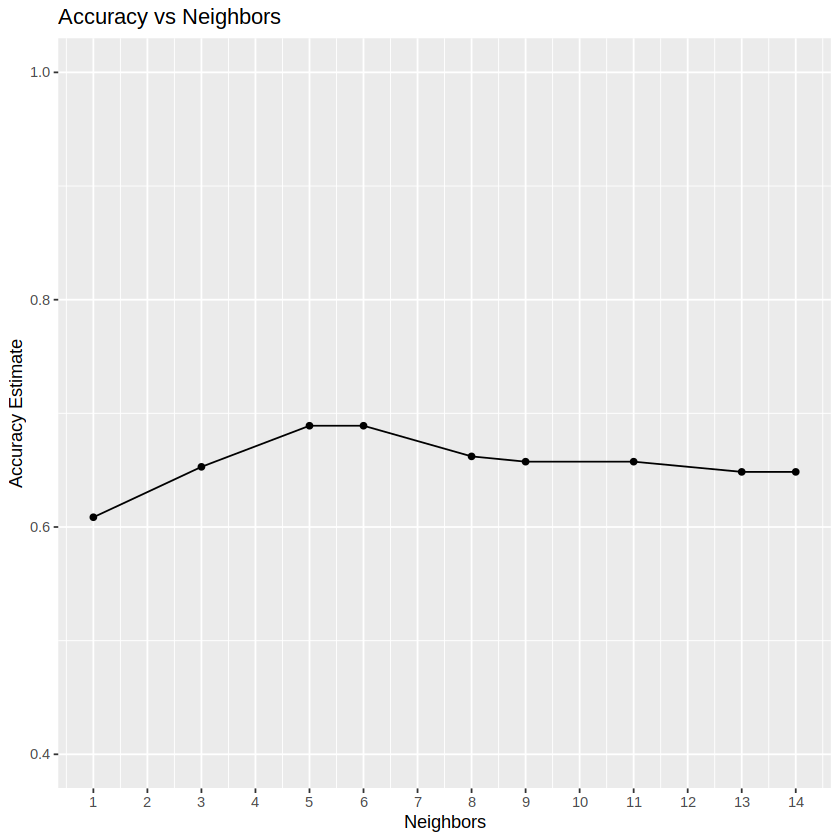

In [10]:
cleveland_accuracy_plot <- ggplot(cleveland_results, aes(x = neighbors, y = mean)) + geom_point() + geom_line() + labs(x = "Neighbors", y = "Accuracy Estimate") + scale_x_continuous(breaks = seq(0, 14, by = 1)) + scale_y_continuous(limits = c(0.4, 1.0)) + ggtitle("Accuracy vs Neighbors")
cleveland_accuracy_plot

This is a plot of the accuracy vs values of neighbours ranging from 1 to 14, which were tested in the kk-nn algorithm. We determined that the highest accuracy comes from the values of 3 and 4, and we chose 3 to remove the possibility of a tie happening in the algorithm. If we chose 4, it could split a 2-2 vote on the conditions of [0,1], which would not work well. The y-axis ranges from 0 to 1, as it measures the percentage of accuracy.


In [11]:
cleveland_best_kknn <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_better_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cleveland_best_kknn) |>
    fit(cleveland_train)

cleveland_test_predictions <- predict(cleveland_better_fit, cleveland_test) |>
                        bind_cols(cleveland_test)

cleveland_conf_mat <- cleveland_test_predictions |>
    conf_mat(truth = condition, estimate = .pred_class)
cleveland_conf_mat

          Truth
Prediction  0  1
         0 25 14
         1 15 21

The truth and prediction table is the confusion matrix for the variables used. A confusion matrix tells us how many of the items are classified correctly. This can be done because the data was split into a training and testing set, with the labels hidden for the testing set so we can test how well our condition will be classified. There are 4 values given from the confusion matrix. The top left number, 30 in this case, shows that 30 values were correctly classified as having the condition 0, meaning there is no heart disease. The bottom right shows that 17 values were correctly classified as 1, meaning the patient does have heart disease. The top left shows that 18 values were classified as 0 when they are actually 1. The bottom left shows that 10 values were classified as 1 when they’re actually 0. This allows us to then calculate different values such as accuracy, precision, and recall. Doing this then allows us to analyze our prediction performance and figure out if we are satisfied with how our data is being classified. Having different values for each of accuracy, precision and recall leads to the data being classified in a different way, so this confusion matrix is quite essential.


Precision: 17/(17+18) = 0.486

Recall: 30/(30+10) = 0.750

Accuracy: (30+17)/(1+30+1+10+18+17) = 0.610

The accuracy shows how well our predictions match the true labels for the observations in the test set, which is 61% here. The reason why the accuracy is not very high might be due to the relatively small sample size, as we only take 222 people of a population to analyze, this may lead to a low accuracy. Precision quantifies how many of the positive predictions the classifier made were actually positive, here is 49%. Recall quantifies how many of the positive observations in the test set were identified as positive, here is 75%. Adequate representation of positive instances in the training data is crucial for the model to learn patterns associated with the positive class. Collecting more diverse and representative training data can improve both precision and recall.

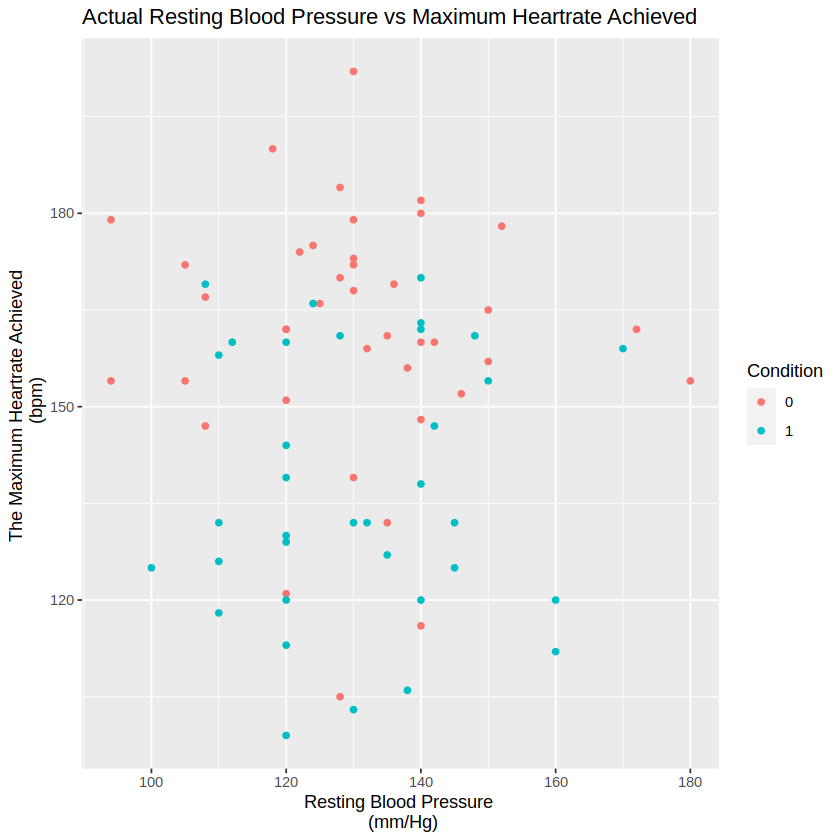

In [12]:
cleveland_actual_plot <- ggplot(cleveland_test, aes(x = trestbps, y = thalach, color = condition)) +
                        geom_point() +
                        labs(x = "Resting Blood Pressure \n (mm/Hg)", y = "The Maximum Heartrate Achieved \n (bpm)", color = "Condition") +
                        ggtitle("Actual Resting Blood Pressure vs Maximum Heartrate Achieved")
cleveland_actual_plot

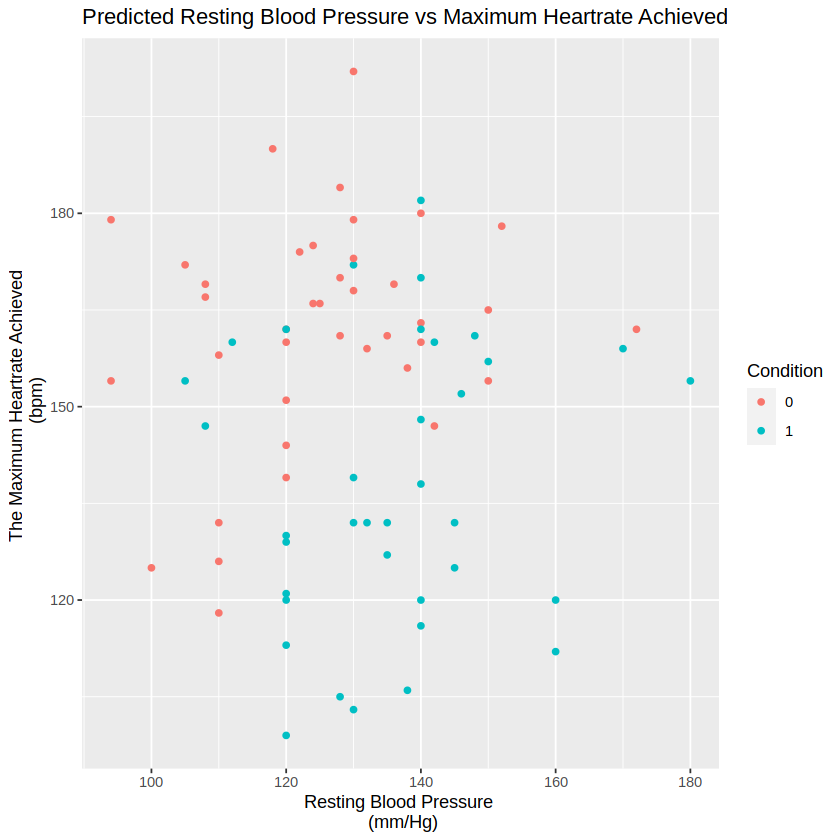

In [13]:
cleveland_predict_plot <- ggplot(cleveland_test_predictions, aes(x = trestbps, y = thalach, color = .pred_class)) +
                            geom_point() +
                            labs(x = "Resting Blood Pressure \n (mm/Hg)", y = "The Maximum Heartrate Achieved \n (bpm)", color = "Condition") +
                        ggtitle("Predicted Resting Blood Pressure vs Maximum Heartrate Achieved")
cleveland_predict_plot                    

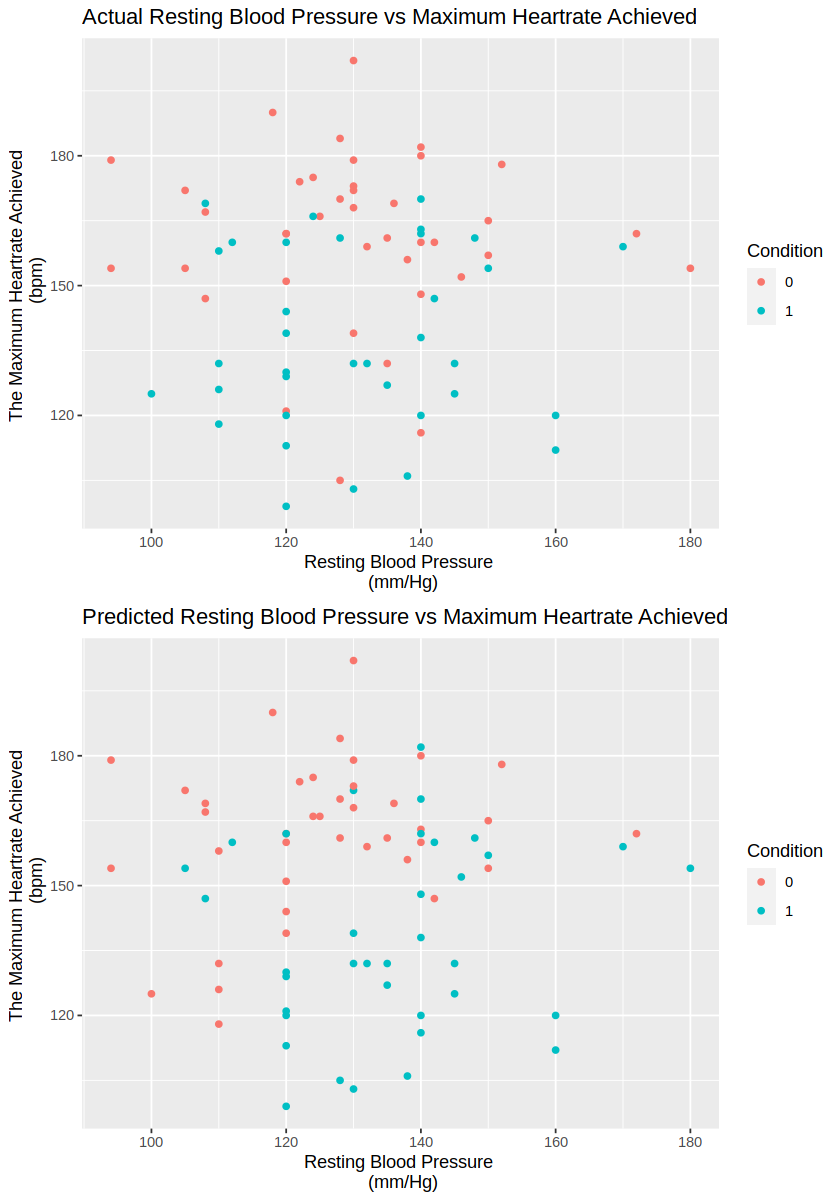

In [18]:
options(repr.plot.width=7, repr.plot.height=10)

grid.arrange(cleveland_actual_plot, cleveland_predict_plot)

Do a ggpairs with all variables.

The question we answered with this project is: how do resting blood pressure, maximum heart rate achieved, and cholesterol influence the percentage of narrowing in any major vessel (condition)? We found that our k-nn classification algorithm has an accuracy of 61%, a precision of 49% and a recall of 75%. We expected to find the relationship of how one's condition is impacted by resting blood pressure, maximum heart rate achieved, and cholesterol. We did not have a strong correlation between all of the variables, and we did not have a strong foundation that proved the variables were related, as the graphs did not show a clear separation of classes. 

Some impacts that these findings could lead to could be that more people will be aware of how likely they are to get heart disease and how their living habits could affect it. Therefore, they could be more careful of their health, specifically the health of their heart. Heart disease findings often influence the development of clinical guidelines for healthcare providers. These guidelines can help standardize the best practices for the management and treatment of heart disease. Understanding the risk factors and causes of heart disease can lead to the development of more effective prevention strategies. This can include lifestyle changes, medications, and public health initiatives to reduce the prevalence of heart disease.

This data analysis could lead to more future questions. As we know which groups of people would be more likely to get heart disease, we can find some methods to prevent it. Another question could be whether the countries where the data is recorded affect the chances of the condition being 0 or 1. We can also wonder how this data has changed throughout the years, as this data is from 2017 and it’s been 6 years. We can also think about what are the most effective lifestyle interventions to prevent heart disease. Researchers may explore the ideal diet, exercise routines, stress management techniques, and behavioural interventions.
